# Purpose


### 2023-05-31
**New in this notebook:**
Instead of doing the ranking and reshaping in pandas/polars, I'll 
- Save the raw inference data to a stating table in BQ
- Run a BQ query to
    - Create the rank column (in a CTE)
    - Reshape the data to the desired target format
    - Insert it into a staging table (`tmp` table for gazette inference?)
    - Copy partition from stating table to prod table
    
By inserting data into the staging table, we ensure that the model outputs match the prod outputs and reduce the chance of blasting data from the prod table.

---

***General steps**
- Pull data for inference from GCS
- Load best model from previous run 
- Run inference on large 1k subreddits (r/de, r/ich_iel, r/fragreddit)
    - Save inference data (raw)


- Reshape data for cache
    - 1 row = subreddit + country + subscribed status. Examples:
        - r/`de` | DE (Germany) | 1 (Subscribed) | {Nested struct of top N users}
        - r/`de` | DE (Germany) | 0 (viewed, but NOT Subscribed) |  {Nested struct of top N users}
        
Open questions:
- Other Geos: For now we'll exclude them because ROW can take up a lot of inference & processing time
    - How do we handle users that have NULL/no Geo?
        - Exclude them
    - How do we handle users from non-target Geos?
        - Exclude them

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import glob
import logging
from logging import info
import os
from pathlib import Path
import json
from typing import List, Union

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
import joblib
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, joblib, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
joblib		v: 1.0.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [4]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228


# Pick top model & upload it to GCS
We'll want to move it to GCS so that we can recover it in kubeflow or elsewhere to run inference in parallel

In [5]:
path_inference_model = Path("/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024")

gcs_inf_model_upload_dir = f"gs://i18n-subreddit-clustering/data/models/pn_model/{path_inference_model.name}"
gcs_inf_model_upload_dir

'gs://i18n-subreddit-clustering/data/models/pn_model/pn_manual_test_2023-05-30_153024'

In [6]:
!ls $path_inference_model

X_test-172807_47.parquet	    model-rf_pre1-train_806431_40.gz
X_train-806431_47.parquet	    model-xgboost-train_20000_40.gz
X_validate-172807_47.parquet	    model-xgboost-train_806431_40.gz
df_train-1152045_52.parquet	    model-xgboost_pre1-train_20000_40.gz
model-hgbc_pre1-train_20000_40.gz   model-xgboost_pre1-train_806431_40.gz
model-hgbc_pre1-train_806431_40.gz  y_test-172807_1.parquet
model-rf-train_20000_40.gz	    y_train-806431_1.parquet
model-rf-train_806431_40.gz	    y_validate-172807_1.parquet
model-rf_pre1-train_20000_40.gz


In [7]:
!echo gsutil -m cp -r $path_inference_model $gcs_inf_model_upload_dir

gsutil -m cp -r /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024 gs://i18n-subreddit-clustering/data/models/pn_model/pn_manual_test_2023-05-30_153024


In [8]:
# !gsutil -m cp -r $path_inference_model $gcs_inf_model_upload_dir

# Load Model & Get list of columns used for training

In [9]:
%%time

model_path = f"{path_inference_model}/model-xgboost_pre1-train_806431_40.gz"
model = joblib.load(
    model_path
)

model

CPU times: user 3.63 s, sys: 11.6 ms, total: 3.64 s
Wall time: 163 ms


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['screen_view_count_14d_log',
                                                                          'user_receives_pn_subreddit_count_t7',
                                                                          'user_receives_pn_t7',
                                                                          'user_receives_pn_t14',
                                                                          'user_receives_pn_t30',
                                                                          'log_user_clicks_pn_...
       

In [10]:
# Get input feature names for modeling
l_feature_names = [
    '__'.join(_.split('__')[1:]) for _ in model.best_estimator_['preprocess'].get_feature_names_out()
]
print(
    f"{len(l_feature_names)} <- Model feature count"
    f"\nFeatures:"
    f"\n  {l_feature_names}"
)

40 <- Model feature count
Features:
  ['screen_view_count_14d_log', 'user_receives_pn_subreddit_count_t7', 'user_receives_pn_t7', 'user_receives_pn_t14', 'user_receives_pn_t30', 'log_user_clicks_pn_t7', 'log_user_clicks_trnd_t7', 'log_post_consumes_30', 'log_num_post_consumes_home_30', 'pct_post_consumes_home_30', 'pct_post_consumes_community_30', 'pct_post_consumes_post_detail_30', 'pct_post_consumes_ios_30', 'pct_post_consumes_android_30', 'pct_post_consumes_nsfw_30', 'num_post_consumes_ios_30', 'num_post_consumes_android_30', 'sub_dau_perc_l28', 'perc_by_country_sd', 'us_screenviews_l14_log', 'us_distinct_posts_viewed_l14_log', 'us_post_screenviews_l14_log', 'us_trend_pn_receive_l14_log', 'us_days_active_ios_l30_pct', 'us_android_days_active_l30_pct', 'us_upvotes_l14', 'us_comments_l14', 'us_posts_l14', 'us_trend_pn_click_l14', 'us_sessions_l14', 'us_ios_days_active_l30', 'us_android_days_active_l30', 'us_days_active_l30', 'users_log_l28', 'seo_users_pct_l28', 'loggedin_users_pct_l2

In [11]:
%%time

# We also need these columns to save the outputs (even if not used for inference directly)
c_user_geo_col = 'user_geo_country_code'
l_ix_cols = [
    'pt',
    'target_subreddit',
    'target_subreddit_id',
    'subscribed',
    c_user_geo_col,  # We'll maybe need to rename it in final table?
    'user_id',
]

# Each row in output table will be at this grain:
l_ix_cache = [
    'pt',
    'target_subreddit_id',
    'target_subreddit',
    'subscribed',
    c_user_geo_col,  # We'll maybe need to rename it in final table?
]

# Other columns for output: These we'll create as part of inference
c_pred_proba = 'click_proba'
#   TODO(djb): this rank also needs to be at SUBSCRIPTION level! subscribers & non-subscribers will have a different rank!
c_user_rank = 'user_rank_by_sub_and_geo'  

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11 µs


In [12]:
# columns to query in BQ table:
set(l_ix_cols + l_feature_names)

{'android_users_pct_l28',
 'ios_users_pct_l28',
 'legacy_user_cohort_ord',
 'log_num_post_consumes_home_30',
 'log_post_consumes_30',
 'log_user_clicks_pn_t7',
 'log_user_clicks_trnd_t7',
 'loggedin_users_pct_l28',
 'num_post_consumes_android_30',
 'num_post_consumes_ios_30',
 'pct_post_consumes_android_30',
 'pct_post_consumes_community_30',
 'pct_post_consumes_home_30',
 'pct_post_consumes_ios_30',
 'pct_post_consumes_nsfw_30',
 'pct_post_consumes_post_detail_30',
 'perc_by_country_sd',
 'pt',
 'screen_view_count_14d_log',
 'seo_users_pct_l28',
 'sub_dau_perc_l28',
 'subscribed',
 'target_subreddit',
 'target_subreddit_id',
 'us_android_days_active_l30',
 'us_android_days_active_l30_pct',
 'us_comments_l14',
 'us_days_active_ios_l30_pct',
 'us_days_active_l30',
 'us_distinct_posts_viewed_l14_log',
 'us_ios_days_active_l30',
 'us_post_screenviews_l14_log',
 'us_posts_l14',
 'us_screenviews_l14_log',
 'us_sessions_l14',
 'us_trend_pn_click_l14',
 'us_trend_pn_receive_l14_log',
 'us_upv

# Load & reshape data

## Export data to GCS

Here we'll export a SAMPLE so we can test the process before running on 26k subreddits

In [13]:
# %%time
# %%bigquery _ --project data-prod-165221/ 

# -- ============
# -- Export data to GCS because querying such a huge table takes forever and a half
# -- ===
# EXPORT DATA OPTIONS(
#     uri='gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/*.parquet',
#     format='PARQUET',
#     overwrite=true
# ) AS

# SELECT
#     pt, target_subreddit, target_subreddit_id, subscribed, user_geo_country_code, user_id
#     , screen_view_count_14d_log, user_receives_pn_subreddit_count_t7, user_receives_pn_t7
#     , user_receives_pn_t14, user_receives_pn_t30, log_user_clicks_pn_t7, log_user_clicks_trnd_t7
#     , log_post_consumes_30, log_num_post_consumes_home_30, pct_post_consumes_home_30, pct_post_consumes_community_30, pct_post_consumes_post_detail_30, pct_post_consumes_ios_30
#     , pct_post_consumes_android_30, pct_post_consumes_nsfw_30, num_post_consumes_ios_30
#     , num_post_consumes_android_30, sub_dau_perc_l28, perc_by_country_sd, us_screenviews_l14_log
#     , us_distinct_posts_viewed_l14_log, us_post_screenviews_l14_log, us_trend_pn_receive_l14_log
#     , us_days_active_ios_l30_pct, us_android_days_active_l30_pct, us_upvotes_l14, us_comments_l14
#     , us_posts_l14, us_trend_pn_click_l14, us_sessions_l14, us_ios_days_active_l30
#     , us_android_days_active_l30, us_days_active_l30, users_log_l28, seo_users_pct_l28
#     , loggedin_users_pct_l28, ios_users_pct_l28, android_users_pct_l28, legacy_user_cohort_ord
# FROM `reddit-employee-datasets.david_bermejo.pn_ft_all_20230530` AS f
#     INNER JOIN (
#         -- Pick top subreddits for sampling/testing
#         SELECT
#             s.subreddit_id, s.subreddit_name
#             , ROW_NUMBER() OVER(ORDER BY users_l7 DESC) AS rank_by_users
#         FROM `reddit-employee-datasets.david_bermejo.pn_ft_subreddits_20230525` AS s

#         WHERE s.pt = '2023-05-29'
#         -- For testing, we can limit to only the top subreddits
#         QUALIFY (
#             rank_by_users <= 2000
#             OR subreddit_name LIKE "%street%"
#             OR subreddit_name LIKE "%figther%"
#         )
#     ) AS sub
#         ON f.target_subreddit_id = sub.subreddit_id

# WHERE pt = '2023-05-29'
# ;



## Download training data from GCS

Here we mostly copy the query used for training. Note that we should match column names.

We uset GCS instead of pulling from BigQuery to save time. We also sync data with `gsutil` instead of trying to read directly from GCS

for 1k subreddits:
- ~1,800 files
- ~50 GB
- ~10 minutes to download with `gsutil`

For 2k subreddits:
- 5,000 files
- ~198 GB
- ~25 minutes to download with `gsutil`


In [14]:
bucket_name = 'i18n-subreddit-clustering'
gcs_inference = f"gs://{bucket_name}/pn_model/runs/inference/20230529_sample/"

path_local_cache = Path(f"/home/jupyter/subreddit_clustering_i18n/data/local_cache/{bucket_name}/")
local_path_inference = path_local_cache / gcs_inference.split(f"{bucket_name}/")[1]
Path.mkdir(local_path_inference, exist_ok=True, parents=True)

print(gcs_inference)
print(local_path_inference)

gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/
/home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample


In [15]:
# !gsutil ls $gcs_inference

In [16]:
# delete in case we exported the wrong data
## !echo gsutil -m rm -r gcs_inference

In [17]:
# try -q (quiet) mode at the end to suppress progress & file list
#. This can be helpful when we have 2k+ files b/c gsutil can overwhelm/freeze the system
#. also try a lower process count (20 seems to freeze, maybe try 10?)

!echo gsutil -o GSUtil:parallel_thread_count=12 -o GSUtil:parallel_process_count=12 -m rsync -r -n $gcs_inference $local_path_inference
print('\n')

!echo gsutil -q -o GSUtil:parallel_thread_count=12 -o GSUtil:parallel_process_count=12 -m rsync -r $gcs_inference $local_path_inference
!echo gsutil -o GSUtil:parallel_thread_count=12 -o GSUtil:parallel_process_count=12 -m rsync -r $gcs_inference $local_path_inference

gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample -q


gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample -q


# Run inference - each file in parallel
For running inference we require pandas because it's the format sklearn/XGBoost expects for inputs. 

~~Because we can't use `polars` for parallel processing, let's just process & run inference on each file individually.
Then, once we've run inference on all files we can move to polars for ranking and clipping, which polars can do well in parallel.~~

NEW: 
<br>forget using polars for post-processing/reshaping! Instead load the raw inference to BQ and then rank & reshape there!

---

ETAs for only `inference` & `save`:
- 0:49 (hh:mins): 47,055,198.9 rows / min | `2,305,704,745` rows with pandas + paralle with `dask` (5k files)
- 1:42 (hh:mins): 22,604,948.5 rows / min | `2,305,704,745` rows with pandas in series [1 file at a time] (5k files)
- 0:21 (hh:mins): 33,617,303.5 rows / min | `0,705,963,374` rows with pandas (1 file)


```bash
# `2,305,704,745` rows with pandas in SERIES [1 file at a time]
42/5000 [00:50<1:41:02, 1.22s/it]

# ---

# `2,305,704,745` rows with pandas in PARALLEL
CPU times: user 15h 54min 6s, sys: 1h 7min 58s, total: 17h 2min 5s
Wall time: 49min 7s

# ---

# Read data. `705,963,374` rows with pandas
CPU times: user 7min 59s, sys: 5min 1s, total: 13min 1s
Wall time: 26 s
(705963374, 26)

# Run inference
18:33:47 | INFO | "Create new df for predictions..."
18:47:44 | INFO | "Done with predictions"
CPU times: user 3h 54min 39s, sys: 3min 2s, total: 3h 57min 41s
Wall time: 13min 56s

# Save inference file (note it might take longer b/c I also added rank column in the previous step)
20:44:55 | INFO | "start saving predictions..."
CPU times: user 5min 45s, sys: 31.3 s, total: 6min 17s
Wall time: 6min 24s
```

To check progress manually, we can run this command from the CLI to count the number of output files:

```bash
ls "/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/" -l | wc -l
# 1473
```

In [62]:
from subclu.pn_models.pn_inference import run_inference_on_one_file

CPU times: user 0 ns, sys: 1.9 ms, total: 1.9 ms
Wall time: 3.53 ms


In [51]:
%%time

f_list = glob.glob(f"{local_path_inference}/*.parquet")
print(len(f_list))
f_list[:1]

5000
CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 15.8 ms


['/home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample/000000004226.parquet']

In [47]:
# define inference path once so that it's the same for all output files
path_this_model_inference = path_this_model / 'inference'

for f_ in tqdm(f_list[:1]):
    run_inference_on_one_file(
        df_path=f_,
        model_path=model_path,
        path_output=path_this_model_inference,
        l_ix_columns=l_ix_cols,
        l_feature_columns=None,
        verbose=False,
    )

  0%|          | 0/1 [00:00<?, ?it/s]

19:09:52 | INFO | "Loading model...
  /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/model-xgboost_pre1-train_806431_40.gz"
19:09:52 | INFO | "40 <- Model feature count"
19:09:52 | INFO | "
Features:
  ['screen_view_count_14d_log', 'user_receives_pn_subreddit_count_t7', 'user_receives_pn_t7', 'user_receives_pn_t14', 'user_receives_pn_t30', 'log_user_clicks_pn_t7', 'log_user_clicks_trnd_t7', 'log_post_consumes_30', 'log_num_post_consumes_home_30', 'pct_post_consumes_home_30', 'pct_post_consumes_community_30', 'pct_post_consumes_post_detail_30', 'pct_post_consumes_ios_30', 'pct_post_consumes_android_30', 'pct_post_consumes_nsfw_30', 'num_post_consumes_ios_30', 'num_post_consumes_android_30', 'sub_dau_perc_l28', 'perc_by_country_sd', 'us_screenviews_l14_log', 'us_distinct_posts_viewed_l14_log', 'us_post_screenviews_l14_log', 'us_trend_pn_receive_l14_log', 'us_days_active_ios_l30_pct', 'us_android_days_active_l30_pct', 'us_upvotes_l14', 'us_co

In [61]:
# !ls $path_this_model_inference

In [56]:
# define inference path once so that it's the same for all output files
path_this_model_inference = path_this_model / 'inference'

# store all the delayed inference files in a list, then we'll compute the list values in parallel with dask
l_inference_files = list()
for f_ in tqdm(f_list):
    l_inference_files.append(
        dask.delayed(run_inference_on_one_file)(
            df_path=f_,
            model_path=model_path,
            path_output=path_this_model_inference,
            l_ix_columns=l_ix_cols,
            l_feature_columns=None,
            verbose=False,
        )
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

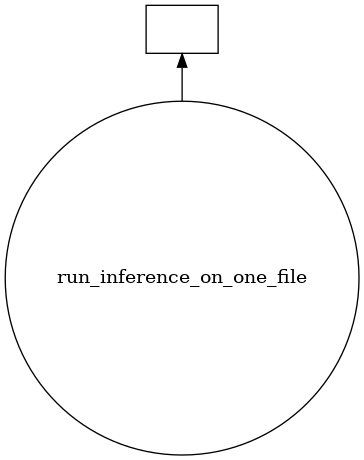

In [59]:
l_inference_files[0].visualize()

### Compute in parallel

To check progress manually, we can run this command from the CLI to count the number of output files:

```bash
ls "/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/" -l | wc -l
# 1473
```

In [66]:
%%time
dask.compute(l_inference_files)
# add print statement to prevent displaying a list of 5k None's
print('')

In [67]:
%%time

l_inference_files_created = glob.glob(f"{path_this_model_inference}/*.parquet")
len(l_inference_files_created)

CPU times: user 11.8 ms, sys: 4.66 ms, total: 16.5 ms
Wall time: 18.1 ms


5000

In [69]:
l_inference_files_created[:5]

['/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000001444.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000002951.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000002408.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000000405.parquet',
 '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference/pred-000000004227.parquet']

## Test load an inference file
check column outputs

In [70]:
%%time
df_inf_check = pd.read_parquet(
    l_inference_files_created[0],
)
df_inf_check.shape

CPU times: user 209 ms, sys: 102 ms, total: 312 ms
Wall time: 225 ms


(462037, 7)

In [71]:
df_inf_check.head()

,pt,target_subreddit,target_subreddit_id,subscribed,user_geo_country_code,user_id,click_proba
0,2023-05-29,de,t5_22i0,0,DE,t2_6qk7v6ig,0.036486
1,2023-05-29,de,t5_22i0,1,DE,t2_c1h49ro6k,0.064660
2,2023-05-29,de,t5_22i0,0,DE,t2_9jzw7gih,0.082675
3,2023-05-29,de,t5_22i0,0,DE,t2_bbo3h71gh,0.060558
4,2023-05-29,de,t5_22i0,1,DE,t2_fjwzq8gk,0.044669


## Upload predictions to GCS!
From GCS we can load it into BigQuery for final ranking & reshaping

In [84]:
path_this_model_inference

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference')

In [83]:
gcs_inference_out = f"{gcs_inference.rstrip('/')}_out/"
gcs_inference_out

'gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/'

In [86]:
!echo gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r -n $path_this_model_inference $gcs_inference_out
print('\n')

!echo gsutil -q -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r $path_this_model_inference $gcs_inference_out
print('\n')
!echo gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r $path_this_model_inference $gcs_inference_out 

gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r -n /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/


gsutil -q -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/


gsutil -o GSUtil:parallel_thread_count=9 -o GSUtil:parallel_process_count=9 -m rsync -r /home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-06-01_190228/inference gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/


## Upload preddictions to BigQuery

By loading to a temp/staging table we can load data from multiple jobs in parallel and run the post-processing in BigQuery which will be faster than to customize in kubeflow

ETA: 2 minutes for 5k files:
```bash
Waiting on bqjob_r849e6f491213b41_000001887911b6cf_1 ... (109s) Current status: DONE
```

In [96]:
%%time

## bq load works, but won't read the "description" or other nice metadata from parquet files
!echo bq load \
    --source_format=PARQUET \
    --project_id=reddit-relevance \
    tmp.i18n_pn_predictions_raw \
    \""$gcs_inference_out"pred*.parquet\"

bq load --source_format=PARQUET --project_id=reddit-relevance tmp.i18n_pn_predictions_raw "gs://i18n-subreddit-clustering/pn_model/runs/inference/20230529_sample_out/pred*.parquet"
CPU times: user 1.42 ms, sys: 332 ms, total: 334 ms
Wall time: 622 ms


In [91]:
%%time

!bq load \
    --source_format=PARQUET \
    --project_id=reddit-relevance \
    tmp.i18n_pn_predictions_raw \
    "$gcs_inference_out"pred*.parquet

BigQuery error in load operation: Access Denied: Project reddit-relevance: User
does not have bigquery.jobs.create permission in project reddit-relevance.
CPU times: user 20.1 ms, sys: 425 ms, total: 445 ms
Wall time: 1.96 s


# BigQuery processing
- rank the users
- reshape output
- save to staging table

In [ ]:
r

In [ ]:
LEGACY

## Load list of subreddits so we can try running in parallel by it
TBD - might try this optimization once I run query for 25k sub.
But for 1k subs I can load in memory (~200 GB).

In [32]:
%%time

df_subreddit_ids = pl.read_parquet(
    f"{local_path_inference}/*.parquet",
    columns=['target_subreddit_id'],
).unique(subset=['target_subreddit_id'], keep='any', maintain_order=False)

df_subreddit_ids.shape

CPU times: user 3min 41s, sys: 14.6 s, total: 3min 55s
Wall time: 9.38 s


(247, 1)

In [33]:
df_subreddit_ids.head()

target_subreddit_id
str
"""t5_2gc1rz"""
"""t5_2kz7we"""
"""t5_20ywkr"""
"""t5_2og1k5"""
"""t5_26tm5u"""


## Load data for inference & caching
Keep the data in a single df so that it's easy to keep track of predictions & match them to the user/geo/subreddit that they belong to for caching

In [31]:
%%time

df_inference_raw = pl.read_parquet(
    f"{local_path_inference}/*.parquet",
    columns=l_ix_cols + l_feature_names
)
df_inference_raw.shape

CPU times: user 7min 59s, sys: 5min 1s, total: 13min 1s
Wall time: 26 s


(705963374, 26)

In [38]:
%%time

(
    df_inference_raw[l_ix_cache]
    .sample(int(200e3))
    .describe()
)

CPU times: user 5.81 s, sys: 99.4 ms, total: 5.91 s
Wall time: 5.25 s


describe,target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top
str,str,str,f64,str
"""count""","""200000""","""200000""",200000.0,"""200000"""
"""null_count""","""0""","""0""",0.0,"""0"""
"""mean""",null,null,0.194765,null
"""std""",null,null,0.396021,null
"""min""","""197""","""t5_10288s""",0.0,"""AR"""
"""max""","""zelda""","""t5_u8wq5""",1.0,"""US"""
"""median""",null,null,0.0,null


There seems to be something off (again) with 2 user_ids... there must be some bad join where subreddit_name is messed up with the wrong subreddit_id.

For now, drop these but I'll need to include subreddit_id as much as possible to prevent such errors later.

In [40]:
%%time
# save the mask so we can re-use it when checking & dropping dupes
mask_dupes_by_user_and_target_sub_ = df_inference_raw.select(['user_id', 'target_subreddit']).is_duplicated()

CPU times: user 11min 54s, sys: 1min 13s, total: 13min 8s
Wall time: 34.7 s


In [41]:
%%time
mask_dupes_by_user_and_target_sub_.sum()

CPU times: user 111 µs, sys: 36 µs, total: 147 µs
Wall time: 162 µs


0

In [42]:
%%time
assert(0 == mask_dupes_by_user_and_target_sub_.sum())

CPU times: user 36 µs, sys: 12 µs, total: 48 µs
Wall time: 60.6 µs


In [43]:
%%time

(
    df_inference_raw
    .filter(mask_dupes_by_user_and_target_sub_)
    .sort(by=['user_id', 'target_subreddit'])
)

CPU times: user 427 ms, sys: 423 ms, total: 851 ms
Wall time: 35.3 ms


target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,tos_30_sub_count,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,screen_view_count_14d,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,tos_30_pct,legacy_user_cohort_ord
str,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,i64


### Remove dupes (if any) [deprecated]
If we have dupes in the inference table, then we have bigger problems about data source so we need to go back and fix them before running inference

In [44]:
df_inference_raw.head()

target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,tos_30_sub_count,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,screen_view_count_14d,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,tos_30_pct,legacy_user_cohort_ord
str,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,i64
"""hydrohomies""","""t5_10288s""",1,"""US""","""t2_ejmd0wgu""",35,33,0,0,0,84,29,51,2,84,0,8,0.095238,null,null,null,null,null,null,0.00526,4
"""hydrohomies""","""t5_10288s""",1,"""US""","""t2_6dsvzqwxi""",10,null,null,null,10,11,0,0,6,0,0,0,0.0,null,null,null,null,null,null,0.20283,5
"""hydrohomies""","""t5_10288s""",1,"""US""","""t2_a262kv7m8""",39,null,null,null,0,649,3,62,559,0,0,0,0.0,null,null,null,null,null,null,0.00141,4
"""hydrohomies""","""t5_10288s""",1,"""US""","""t2_a0y3gfeq3""",7,28,1,1,3,96,45,46,5,96,0,0,0.0,null,null,null,null,null,null,0.00388,4
"""hydrohomies""","""t5_10288s""",1,"""US""","""t2_77dqdzpdd""",13,null,null,null,0,21,0,1,2,0,0,0,0.0,null,null,null,null,null,null,0.03353,4


# Run inference

For 705,963,374 (705 million) rows, ETA:
- Inference: 13 minutes
- Ranking:
- Sorting:


In [47]:
df_inference_raw.head().to_pandas()

,target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,tos_30_sub_count,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,screen_view_count_14d,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,tos_30_pct,legacy_user_cohort_ord
0,hydrohomies,t5_10288s,1,US,t2_ejmd0wgu,35,33.0,0.0,0.0,0,84,29,51,2,84,0,8,0.095238,NaN,NaN,NaN,NaN,NaN,NaN,0.00526,4
1,hydrohomies,t5_10288s,1,US,t2_6dsvzqwxi,10,NaN,NaN,NaN,10,11,0,0,6,0,0,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.20283,5
2,hydrohomies,t5_10288s,1,US,t2_a262kv7m8,39,NaN,NaN,NaN,0,649,3,62,559,0,0,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.00141,4
3,hydrohomies,t5_10288s,1,US,t2_a0y3gfeq3,7,28.0,1.0,1.0,3,96,45,46,5,96,0,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.00388,4
4,hydrohomies,t5_10288s,1,US,t2_77dqdzpdd,13,NaN,NaN,NaN,0,21,0,1,2,0,0,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.03353,4


In [58]:
%%time

# Note that sklearn works only with numpy and pandas
#. let's use pandas because that will preserve column names

info(f"Create new df for predictions...")
_ = (
    df_inference_raw[l_ix_cols].head().to_pandas()
    .assign(
        **{c_pred_proba: model.predict_proba(df_inference_raw[l_feature_names].head().to_pandas())[:,1]}
    ) 
)
_.shape

18:33:14 | INFO | "Create new df for predictions..."


CPU times: user 17.3 ms, sys: 4.5 ms, total: 21.8 ms
Wall time: 19 ms


(5, 6)

In [59]:
_.head()

,target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,click_proba
0,hydrohomies,t5_10288s,1,US,t2_ejmd0wgu,0.073633
1,hydrohomies,t5_10288s,1,US,t2_6dsvzqwxi,0.177742
2,hydrohomies,t5_10288s,1,US,t2_a262kv7m8,0.105416
3,hydrohomies,t5_10288s,1,US,t2_a0y3gfeq3,0.110343
4,hydrohomies,t5_10288s,1,US,t2_77dqdzpdd,0.456919


In [60]:
%%time

info(f"Create new df for predictions...")
df_pred = (
    df_inference_raw[l_ix_cols].to_pandas()
    .assign(
        **{c_pred_proba: model.predict_proba(df_inference_raw[l_feature_names].to_pandas())[:,1]}
    ) 
)
info(f"Done with predictions")

18:33:47 | INFO | "Create new df for predictions..."
18:47:44 | INFO | "Done with predictions"


CPU times: user 3h 54min 39s, sys: 3min 2s, total: 3h 57min 41s
Wall time: 13min 56s


In [63]:
info(f"{df_pred.shape} <- predictions shape")

19:23:21 | INFO | "(705963374, 6) <- predictions shape"


In [64]:
df_pred.head()

,target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,click_proba
0,hydrohomies,t5_10288s,1,US,t2_ejmd0wgu,0.073633
1,hydrohomies,t5_10288s,1,US,t2_6dsvzqwxi,0.177742
2,hydrohomies,t5_10288s,1,US,t2_a262kv7m8,0.105416
3,hydrohomies,t5_10288s,1,US,t2_a0y3gfeq3,0.110343
4,hydrohomies,t5_10288s,1,US,t2_77dqdzpdd,0.456919


```bash
# Rank, pandas
CPU times: user 10min 55s, sys: 26.9 s, total: 11min 22s
Wall time: 11min 21s
    
# Sort, pandas
CPU times: user 9min 48s, sys: 1min 4s, total: 10min 52s
Wall time: 10min 52s

```

In [65]:
%%time

# for the cache we only keep the top ~500k per subreddit+country
# create new column for ranking so that it's easier to filter down the road
df_pred[c_user_rank] = (
    df_pred
    .groupby(l_ix_cache)
    [c_pred_proba]
    .rank(method='dense', ascending=False)
    .astype(int)
)

CPU times: user 10min 55s, sys: 26.9 s, total: 11min 22s
Wall time: 11min 21s


In [67]:
%%time
# Sort the df so that the final file is in the right order
df_pred = (
    df_pred
    .sort_values(by=l_ix_cache + [c_user_rank], ascending=True)
)


CPU times: user 9min 48s, sys: 1min 4s, total: 10min 52s
Wall time: 10min 52s


In [69]:
df_pred.shape

(705963374, 7)

In [70]:
df_pred.head()

,target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,click_proba,user_rank_by_sub_and_geo
625174570,197,t5_3enhu,0,AR,t2_817w7itp,0.967264,1
625128078,197,t5_3enhu,0,AR,t2_8w7diilx,0.952187,2
625205293,197,t5_3enhu,0,AR,t2_793p13o1,0.943688,3
625135565,197,t5_3enhu,0,AR,t2_6abg4aih,0.941869,4
625282083,197,t5_3enhu,0,AR,t2_7dtlpsiq,0.941032,5


# Save raw inference

In [121]:
%%time

info(f"start saving predictions...")
# for prod: might need to use dask or polars to save to multiple files
r_, c_ = df_pred.shape
df_pred.to_parquet(
    path_this_model / f"df_pred-{r_}_{c_}.parquet"
    , index=False
)
del r_, c_

20:44:55 | INFO | "start saving predictions..."


CPU times: user 5min 45s, sys: 31.3 s, total: 6min 17s
Wall time: 6min 24s


In [122]:
!du -Lsh $path_this_model/* | sort -hr 

12G	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/df_pred-705963374_7.parquet


In [129]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705963374 entries, 625174570 to 268279029
Data columns (total 7 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   target_subreddit           object 
 1   target_subreddit_id        object 
 2   subscribed                 int64  
 3   user_geo_country_code_top  object 
 4   user_id                    object 
 5   click_proba                float32
 6   user_rank_by_sub_and_geo   int64  
dtypes: float32(1), int64(2), object(4)
memory usage: 39.4+ GB


# Select cache & Reshape for BigQuery
We won't save all predictions to BigQuery. We only keep those above threshold that gets us over 90% recall (~0.300 in latest XGBoost-pre model)

## Create metadata 
This metadata will be used for all items in this batch. Set it in a dict and save it only to the final data because it can add a ton of overhead to save it for all rows of inference

In [187]:
%%time

d_topk_meta = {
    'pt': '2023-05-07',
    'model_name': 'PN click subreddit-user',
    'model_version': 'v0.1 2023-05-02',
}

# Only check if we've already written it to the file
# info(f"Checking keys for ndjson...")
# for k in tqdm(d_topk_meta.keys()):
#     assert 1 == df_pred[k].nunique()
#     d_topk_meta[k] = df_pred[k].values[0]
#     print(f"  {k}: {d_topk_meta[k]}")

CPU times: user 21 µs, sys: 1 µs, total: 22 µs
Wall time: 42.7 µs


In [124]:
df_pred.columns

Index(['target_subreddit', 'target_subreddit_id', 'subscribed', 'user_geo_country_code_top', 'user_id', 'click_proba', 'user_rank_by_sub_and_geo'], dtype='object')

In [125]:
%%time

n_unique_subs = df_pred['target_subreddit_id'].nunique()

CPU times: user 1min 3s, sys: 3.37 s, total: 1min 6s
Wall time: 1min 6s


## Save as ndJSON

When we apply cache filters, it makes sense to do it upfront (on the whole df) instead of per each subreddit+country

```bash
# time doing filters per group
CPU times: user 1min 2s, sys: 5.5 s, total: 1min 8s
Wall time: 1min 8s
    
# time applying mask upfront - we save ~16 seconds (which will add up when we run on 50k subreddits)
CPU times: user 48.4 s, sys: 3.71 s, total: 52.2 s
Wall time: 52.1 s
```

In [136]:
from subclu.pn_models import pn_inference

In [96]:
%%time
## test on a sample to make sure format is correct
df_pred_sample = df_pred.sample(n=20987000, random_state=42)

CPU times: user 1min 1s, sys: 4.9 s, total: 1min 5s
Wall time: 1min 5s


In [161]:
%%time

p_ndjson_subfolder_test = 'click_proba_ndjson_TEST'

d_ndjson_sample = pn_inference.apply_filters_and_save_to_json(
    df=df_pred_sample,
    path_local_save=path_this_model,
    ndjson_subfolder=p_ndjson_subfolder_test,
    d_model_meta=d_topk_meta,
    n_max_user_rank=960,
    col_user_rank=c_user_rank,
    click_prob_threshold_min=0.100,
    col_click_prob=c_pred_proba,
    l_ix_cache=l_ix_cache,
    batch_num=0,
    file_timestamp=manual_model_timestamp,
    d_rename_ix_cols={'user_geo_country_code_top': 'user_geo_country_code'},
    verbose=False,
)

05:28:46 | INFO | "Creating mask for user to process..."
05:28:46 | INFO | "5,248,995 <- Rows to process"
05:28:46 | INFO | "Creating paths for file..."
05:28:46 | INFO | "Output file:
/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json"
05:28:46 | INFO | "  No previous file found to delete
  [Errno 2] No such file or directory: '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json'"
05:28:46 | INFO | "Start saving df as ndJSON..."
100%|██████████| 34742/34742 [01:00<00:00, 575.01it/s]
05:29:57 | INFO | "Done saving as ndJSON"


Example subreddit:
pt:  2022-05-07
model_name:  PN click subreddit-user
model_version:  v0.1 2023-05-02
target_subreddit_id:  t5_u8wq5
target_subreddit:  themandaloriantv
subscribed:  1
user_geo_country_code:  US
top_users:
    {'user_id': 't2_54ja0o6o', 'click_proba': 0.9758098721504211, 'user_rank_by_sub_and_geo': 1}
    {'user_id': 't2_6zyg0j1w1', 'click_proba': 0.9575957655906677, 'user_rank_by_sub_and_geo': 2}
    {'user_id': 't2_52u9io99', 'click_proba': 0.9371027946472168, 'user_rank_by_sub_and_geo': 3}
    {'user_id': 't2_1i66qvq', 'click_proba': 0.9162823557853699, 'user_rank_by_sub_and_geo': 4}
    {'user_id': 't2_p2kmvy3', 'click_proba': 0.9097001552581787, 'user_rank_by_sub_and_geo': 5}
CPU times: user 1min 7s, sys: 3.28 s, total: 1min 11s
Wall time: 1min 11s


In [166]:
d_ndjson_sample

{'rows_processed': 5248995,
 'local_json_folder': PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST'),
 'local_json_filename': 'click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json',
 'local_json_file': PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json')}

In [162]:
!du -Lsh $path_this_model/* | sort -hr

12G	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/df_pred-705963374_7.parquet
972M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST


In [168]:
test_path_ = d_ndjson_sample['local_json_folder']
!du -Lsh $test_path_/* | sort -hr 

487M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json


In [165]:
test_file_ = d_ndjson_sample['local_json_file']

!head -2 $test_file_ 

{"pt": "2022-05-07", "model_name": "PN click subreddit-user", "model_version": "v0.1 2023-05-02", "target_subreddit_id": "t5_10288s", "target_subreddit": "hydrohomies", "subscribed": 0, "user_geo_country_code": "AR", "top_users": [{"user_id": "t2_16krmx", "click_proba": 0.6672725081443787, "user_rank_by_sub_and_geo": 1}, {"user_id": "t2_5igtl03", "click_proba": 0.3555777072906494, "user_rank_by_sub_and_geo": 2}, {"user_id": "t2_n1juem41", "click_proba": 0.2663317918777466, "user_rank_by_sub_and_geo": 3}]}
{"pt": "2022-05-07", "model_name": "PN click subreddit-user", "model_version": "v0.1 2023-05-02", "target_subreddit_id": "t5_10288s", "target_subreddit": "hydrohomies", "subscribed": 0, "user_geo_country_code": "AT", "top_users": [{"user_id": "t2_3l4m102v", "click_proba": 0.5421475172042847, "user_rank_by_sub_and_geo": 1}, {"user_id": "t2_9tklpqgq2", "click_proba": 0.4820619225502014, "user_rank_by_sub_and_geo": 2}, {"user_id": "t2_9uqci27gs", "click_proba": 0.3086017668247223, "user_

## Upload to GCS
BigQuery expects the data in GCS 

In [172]:
d_ndjson_sample['local_json_file']

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json')

In [174]:
remote_gs_path_json_test = (
    "gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/"
)

In [176]:
BREAK
f_local_json_test_ = d_ndjson_sample['local_json_file']

!gsutil -m cp -r -n $f_local_json_test_ $remote_gs_path_json_test

Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json [Content-Type=application/json]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1/1 files][486.7 MiB/486.7 MiB] 100% Done                                    
Operatio

In [177]:
!gsutil ls $remote_gs_path_json_test

gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json


In [184]:
BREAK
remote_gs_file_json_test = (
    "gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/*.json"
)

## Upload to BigQuery

In [180]:
from subclu.pn_models.bq_schemas import pn_model_schema
from subclu.utils.big_query_utils import load_data_to_bq_table

In [ ]:
BREAK

In [186]:
%%time


load_data_to_bq_table(
    uri=remote_gs_file_json_test,
    bq_project='reddit-employee-datasets',
    bq_dataset='david_bermejo',
    bq_table_name='pn_model_output_test_20230510',
    schema=pn_model_schema(),
    partition_column='pt',
    table_description=(
        "Cache model output with the users from a country that are most likely to click on a PN from a target subreddit"
    ),
    update_table_description=True,
)

05:51:17 | INFO | "Loading this URI:
  gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/*.json
Into this table:
  reddit-employee-datasets.david_bermejo.pn_model_output_test_20230510"
05:51:17 | INFO | "Created table reddit-employee-datasets.david_bermejo.pn_model_output_test_20230510"
05:51:18 | INFO | "  0 rows in table BEFORE adding data"
05:51:52 | INFO | "Original Table Expiration: 2023-08-19 05:51:17.791000+00:00"
05:51:53 | INFO | "NEW Table Expiration: None"
05:51:53 | INFO | "Updating subreddit description from:
  Cache model output with the users from a country that are most likely to click on a PN from a target subreddit
to:
  Cache model output with the users from a country that are most likely to click on a PN from a target subreddit"
05:51:53 | INFO | "  34,742 rows in table AFTER adding data"


CPU times: user 71.8 ms, sys: 1.37 s, total: 1.44 s
Wall time: 39.8 s


# Run Transformation to ndjson on full data!
Now that we tested that it works on sample, test on full data

In [191]:
%%time
p_ndjson_subfolder = 'click_proba_ndjson'

d_ndjson = pn_inference.apply_filters_and_save_to_json(
    df=df_pred,
    path_local_save=path_this_model,
    ndjson_subfolder=p_ndjson_subfolder,
    d_model_meta=d_topk_meta,
    n_max_user_rank=500000,
    col_user_rank=c_user_rank,
    click_prob_threshold_min=0.100,
    col_click_prob=c_pred_proba,
    l_ix_cache=l_ix_cache,
    batch_num=0,
    file_timestamp=manual_model_timestamp,
    d_rename_ix_cols={'user_geo_country_code_top': 'user_geo_country_code'},
    verbose=False,
)

06:02:19 | INFO | "Creating mask for user to process..."
06:02:22 | INFO | "376,701,575 <- Rows to process"
06:02:22 | INFO | "Creating paths for file..."
06:02:22 | INFO | "Output file:
/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson/click_proba_ndjson-0-2023-05-10_162703-376701575_rows.json"
06:02:22 | INFO | "  No previous file found to delete
  [Errno 2] No such file or directory: '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson/click_proba_ndjson-0-2023-05-10_162703-376701575_rows.json'"
06:02:22 | INFO | "Start saving df as ndJSON..."
100%|██████████| 35967/35967 [39:06<00:00, 15.33it/s]  
06:52:35 | INFO | "Done saving as ndJSON"


Example subreddit:
pt:  2023-05-07
model_name:  PN click subreddit-user
model_version:  v0.1 2023-05-02
target_subreddit_id:  t5_u8wq5
target_subreddit:  themandaloriantv
subscribed:  1
user_geo_country_code:  US
top_users:
    {'user_id': 't2_5kifarq', 'click_proba': 0.9884856939315796, 'user_rank_by_sub_and_geo': 1}
    {'user_id': 't2_11bmsm', 'click_proba': 0.9850019812583923, 'user_rank_by_sub_and_geo': 2}
    {'user_id': 't2_1k14y9ld', 'click_proba': 0.9843473434448242, 'user_rank_by_sub_and_geo': 3}
    {'user_id': 't2_fzmk4', 'click_proba': 0.9816073179244995, 'user_rank_by_sub_and_geo': 4}
    {'user_id': 't2_4kd068j1', 'click_proba': 0.9787896275520325, 'user_rank_by_sub_and_geo': 5}
CPU times: user 47min 39s, sys: 2min 59s, total: 50min 39s
Wall time: 50min 38s


In [192]:
!du -Lsh $path_this_model/* | sort -hr 

35G	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson
12G	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/df_pred-705963374_7.parquet
487M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST


## Upload to GCS
BigQuery expects the data in GCS 

In [193]:
d_ndjson['local_json_file']

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson/click_proba_ndjson-0-2023-05-10_162703-376701575_rows.json')

In [194]:
remote_gs_path_json = (
    "gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson/"
)

In [202]:
# BREAK
f_local_json_ = d_ndjson['local_json_file']

!gsutil -m cp -r -n $f_local_json_ $remote_gs_path_json

Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson/click_proba_ndjson-0-2023-05-10_162703-376701575_rows.json [Content-Type=application/json]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

^C[0/1 files][  5.9 GiB/ 34.5 GiB]  17% Done 159.2 MiB/s ETA 00:03:04           


In [196]:
!gsutil ls $remote_gs_path_json_test

gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-376701575_rows.json
gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-5248995_rows.json


In [204]:
!gsutil ls $remote_gs_path_json

CommandException: One or more URLs matched no objects.


In [203]:
# BREAK
remote_gs_file_json = (
    "gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-376701575_rows.json"
)

## Upload to BigQuery

In [180]:
from subclu.pn_models.bq_schemas import pn_model_schema
from subclu.utils.big_query_utils import load_data_to_bq_table

In [ ]:
BREAK

In [205]:
%%time

load_data_to_bq_table(
    uri=remote_gs_file_json,
    bq_project='reddit-employee-datasets',
    bq_dataset='david_bermejo',
    bq_table_name='pn_model_output_20230510',
    schema=pn_model_schema(),
    partition_column='pt',
    table_description=(
        "Cache model output with the users from a country that are most likely to click on a PN from a target subreddit"
    ),
    update_table_description=True,
)

12:52:03 | INFO | "Loading this URI:
  gs://i18n-subreddit-clustering/pn_model/pn_manual_test_2023-05-10_162703/click_proba_ndjson_TEST/click_proba_ndjson-0-2023-05-10_162703-376701575_rows.json
Into this table:
  reddit-employee-datasets.david_bermejo.pn_model_output_20230510"
12:52:04 | INFO | "Table reddit-employee-datasets.david_bermejo.pn_model_output_20230510 already exist"
12:52:04 | INFO | "  0 rows in table BEFORE adding data"
12:53:18 | INFO | "Original Table Expiration: 2023-08-19 12:48:36.252000+00:00"
12:53:19 | INFO | "NEW Table Expiration: None"
12:53:19 | INFO | "Updating subreddit description from:
  Cache model output with the users from a country that are most likely to click on a PN from a target subreddit
to:
  Cache model output with the users from a country that are most likely to click on a PN from a target subreddit"
12:53:19 | INFO | "  35,967 rows in table AFTER adding data"


CPU times: user 68.1 ms, sys: 1.16 s, total: 1.22 s
Wall time: 1min 18s


# Appendix / EDA


In [ ]:
LEGACY

### Test speed in pandas v. polars

In [96]:
%%time

df_pred_sample = df_pred.sample(n=20987000, random_state=42)

CPU times: user 1min 1s, sys: 4.9 s, total: 1min 5s
Wall time: 1min 5s


### Ranking


Speed benchmarks
```bash
# Rank
## polars (only slightly faster, but it's because it has to conver the pandas df to polars DF first)
CPU times: user 36.6 s, sys: 6.26 s, total: 42.8 s
Wall time: 15.9 s
(20987000, 7)

## pandas
CPU times: user 16.5 s, sys: 719 ms, total: 17.2 s
Wall time: 17.2 s
(20987000, 7)


# Sort
## Polars (10x faster!)
CPU times: user 2min 2s, sys: 3.26 s, total: 2min 5s
Wall time: 2.04 s

## pandas
CPU times: user 23.7 s, sys: 2.99 s, total: 26.7 s
Wall time: 26.7 s
```

In [100]:
%%time

# for the cache we only keep the top ~500k per subreddit+country
# create new column for ranking so that it's easier to filter down the road
# Test rank with polars


df_pred_sample_pl = (
    pl.DataFrame(df_pred_sample)
    .with_columns(
        pl.col(c_pred_proba)
        .rank(method='dense', descending=True)
        .over(l_ix_cache)
        .alias(c_user_rank)
    )

)
df_pred_sample_pl.shape

CPU times: user 36.6 s, sys: 6.26 s, total: 42.8 s
Wall time: 15.9 s


(20987000, 7)

In [101]:
df_pred_sample_pl.head()

target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,click_proba,user_rank_by_sub_and_geo
str,str,i64,str,str,f32,u32
"""okmatewanker""","""t5_2v1zrq""",0,"""GB""","""t2_9zp38ac7f""",0.113392,820
"""catadvice""","""t5_2sn56""",0,"""GB""","""t2_892xhrl0q""",0.174089,277
"""denver""","""t5_2qn3i""",1,"""US""","""t2_hmyowarc""",0.037492,1755
"""mildlyinfuriat…","""t5_2ubgg""",0,"""AU""","""t2_3h70puy0""",0.055622,5308
"""memes""","""t5_2qjpg""",0,"""US""","""t2_qzs576tm""",0.052112,24706


In [105]:
%%time

# for the cache we only keep the top ~500k per subreddit+country
# create new column for ranking so that it's easier to filter down the road
# Test rank with pandas

df_pred_sample[c_user_rank] = (
    df_pred_sample
    .groupby(l_ix_cache)
    [c_pred_proba]
    .rank(method='dense', ascending=False)
    .astype(int)
)
df_pred_sample.shape

CPU times: user 16.5 s, sys: 719 ms, total: 17.2 s
Wall time: 17.2 s


(20987000, 7)

### Sorting

In [106]:
%%time
# Sort the df so that the final file is in the right order
df_pred_sample = (
    df_pred_sample.sort_values(by=l_ix_cache + [c_user_rank], ascending=True)
)


CPU times: user 23.7 s, sys: 2.99 s, total: 26.7 s
Wall time: 26.7 s


In [110]:
%%time
# Sort the df so that the final file is in the right order
df_pred_sample_pl = (
    df_pred_sample_pl.sort(by=l_ix_cache + [c_user_rank], descending=False)
)

CPU times: user 2min 3s, sys: 2.76 s, total: 2min 6s
Wall time: 1.99 s


In [111]:
df_pred_sample_pl.head()

target_subreddit,target_subreddit_id,subscribed,user_geo_country_code_top,user_id,click_proba,user_rank_by_sub_and_geo
str,str,i64,str,str,f32,u32
"""197""","""t5_3enhu""",0,"""AR""","""t2_12yxa2""",0.794768,1
"""197""","""t5_3enhu""",0,"""AR""","""t2_7d8owdn5""",0.522817,2
"""197""","""t5_3enhu""",0,"""AR""","""t2_6h7f9rog""",0.435153,3
"""197""","""t5_3enhu""",0,"""AR""","""t2_5c4zm26h""",0.241061,4
"""197""","""t5_3enhu""",0,"""AR""","""t2_db62ugqx""",0.225995,5



## TODO - check filtering logic
Check whether the filtering logic I had in mind makes sense instead of scoring ALL the users...?

But maybe scoring all the users is fast/cheap enough that it's fine to score a few million users to get the top 500k per country?

---

Cuts to check for proba for ALL users
- by subscribe v. not subscribe
- by country (all)
- by legacy cohort
- by subreddit + 
    - country
    - cohort
    - by subscribe

Cuts to check for proba for only top 500k users per country (the ones that will be cached).
<br>Note that some countries won't have that many users per subreddit because not enough people visit them

## Project how many users per sub+country with some thresholds
This is helpful to know how many we'll have in the final cache table before writing to it

In [107]:
%%time

mask_pred_above_0250 = (df_pred[c_pred_proba] >= 0.250)
mask_pred_above_0200 = (df_pred[c_pred_proba] >= 0.200)
mask_pred_above_0150 = (df_pred[c_pred_proba] >= 0.150)
mask_pred_above_0100 = (df_pred[c_pred_proba] >= 0.100)

mask_rank_below_500k = (df_pred[c_user_rank] <= 500000)

print(f"{mask_pred_above_0100.sum():,.0f} Users above 0.100")
print(f"{mask_pred_above_0150.sum():,.0f} Users above 0.150")
print(f"{mask_pred_above_0200.sum():,.0f} Users above 0.200")
print(f"{mask_pred_above_0250.sum():,.0f} Users above 0.250")

print(f"{mask_rank_below_500k.sum():,.0f} Users below 500k rank")

11,849,601 Users above 0.100
10,763,902 Users above 0.150
9,807,071 Users above 0.200
8,753,948 Users above 0.250
8,383,463 Users below 500k rank
CPU times: user 136 ms, sys: 3.79 ms, total: 140 ms
Wall time: 138 ms


In [110]:
display(
    style_df_numeric(
        df_pred[c_pred_proba]
        .describe(percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]).to_frame().T,
        float_round=4,
        l_bar_simple=['mean', '50%'],
    ).set_caption(f"All users")
)

display(
    style_df_numeric(
        df_pred
        [mask_rank_below_500k]
        [c_pred_proba]
        .describe(percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]).to_frame().T,
        float_round=4,
        l_bar_simple=['mean', '50%']
    ).set_caption(f"Users below 500k rank")
)

display(
    style_df_numeric(
        df_pred
        [mask_pred_above_0100 & mask_rank_below_500k]
        [c_pred_proba]
        .describe(percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]).to_frame().T,
        float_round=4,
        l_bar_simple=['mean', '50%']
    ).set_caption(f"Users below 500k rank AND above 0.100 Threshold")
)

,count,mean,std,min,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,95%,99%,max
click_proba,"17,486,678",0.2807,0.2276,0.0000,0.0242,0.0468,0.0617,0.0857,0.1639,0.2505,0.3294,0.4030,0.4454,0.4906,0.6011,0.6797,0.8826,0.9975


,count,mean,std,min,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,95%,99%,max
click_proba,"8,383,463",0.4011,0.2365,0.0000,0.0468,0.1391,0.2162,0.2828,0.3612,0.4107,0.4774,0.5486,0.5767,0.6063,0.6852,0.7950,0.9240,0.9975


,count,mean,std,min,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,95%,99%,max
click_proba,"6,938,439",0.4755,0.1880,0.1000,0.2238,0.3203,0.3488,0.3649,0.4131,0.4664,0.5268,0.5777,0.6021,0.6276,0.7133,0.8192,0.9316,0.9975


In [116]:
display(
    style_df_numeric(
        df_pred
        .groupby(['target_subreddit'])
        [c_pred_proba]
        .describe(
            # percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
        ),
        float_round=4,
        l_bar_simple=['mean', '50%']
    ).set_caption(f"All users")
)

display(
    style_df_numeric(
        df_pred
        [mask_pred_above_0100 & mask_rank_below_500k]
        .groupby(['target_subreddit'])
        [c_pred_proba]
        .describe(
            # percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
        ),
        float_round=4,
        l_bar_simple=['mean', '50%']
    ).set_caption(f"Users below 500k rank AND above 0.100 Threshold")
)

,count,mean,std,min,25%,50%,75%,max
target_subreddit,,,,,,,,
de,"7,275,629",0.2777,0.2277,0.0000,0.0588,0.2464,0.4417,0.9975
fragreddit,"2,220,353",0.2607,0.2186,0.0000,0.0560,0.2329,0.4045,0.9970
ich_iel,"7,990,696",0.2890,0.2295,0.0000,0.0662,0.2607,0.4609,0.9969


,count,mean,std,min,25%,50%,75%,max
target_subreddit,,,,,,,,
de,"2,881,638",0.4775,0.1871,0.1000,0.3542,0.4786,0.6013,0.9975
fragreddit,"1,043,029",0.4463,0.1685,0.1000,0.3367,0.4158,0.5378,0.9970
ich_iel,"3,013,772",0.4837,0.1941,0.1000,0.3500,0.4839,0.6158,0.9969


In [117]:
display(
    style_df_numeric(
        df_pred
        .groupby(['geo_country_code_top'])
        [c_pred_proba]
        .describe(
            # percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
        )
        .sort_values(by=['50%'], ascending=False)
        ,
        float_round=4,
        l_bar_simple=['mean', '50%']
    ).set_caption(f"All users")
)

display(
    style_df_numeric(
        df_pred
        [mask_pred_above_0100 & mask_rank_below_500k]
        .groupby(['geo_country_code_top'])
        [c_pred_proba]
        .describe(
            # percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
        )
        .sort_values(by=['50%'], ascending=False)
        ,
        float_round=4,
        l_bar_simple=['mean', '50%']
    ).set_caption(f"Users below 500k rank AND above 0.100 Threshold")
)

,count,mean,std,min,25%,50%,75%,max
geo_country_code_top,,,,,,,,
US,"6,420,802",0.2992,0.2313,0.0000,0.0753,0.2706,0.4837,0.9964
MISSING,"653,018",0.2667,0.1476,0.0003,0.1526,0.2676,0.3700,0.9247
IN,"131,692",0.3027,0.2552,0.0000,0.0526,0.2671,0.4927,0.9948
MX,"58,348",0.2959,0.2414,0.0001,0.0569,0.2638,0.4851,0.9838
GB,"599,161",0.2969,0.2525,0.0000,0.0492,0.2583,0.5007,0.9949
PH,"42,307",0.2983,0.2590,0.0002,0.0496,0.2551,0.4998,0.9845
PT,"38,341",0.2989,0.2641,0.0001,0.0476,0.2484,0.5139,0.9858
IT,"58,498",0.2945,0.2544,0.0001,0.0509,0.2480,0.4900,0.9902
ROW,"1,571,790",0.2842,0.2423,0.0000,0.0507,0.2464,0.4638,0.9933


,count,mean,std,min,25%,50%,75%,max
geo_country_code_top,,,,,,,,
US,"1,302,789",0.6333,0.1264,0.1000,0.5703,0.6189,0.6860,0.9964
DE,"2,272,361",0.4895,0.1441,0.2914,0.3808,0.4515,0.5571,0.9975
PT,"23,799",0.4576,0.2137,0.1000,0.2875,0.4452,0.6103,0.9858
GB,"383,955",0.4414,0.2027,0.1000,0.2784,0.4355,0.5840,0.9949
PH,"26,629",0.4498,0.2105,0.1000,0.2840,0.4346,0.5950,0.9845
AU,"175,534",0.4333,0.1978,0.1000,0.2704,0.4334,0.5775,0.9853
IE,"38,211",0.4363,0.2084,0.1000,0.2657,0.4220,0.5814,0.9919
CA,"399,919",0.4234,0.1978,0.1000,0.2604,0.4182,0.5638,0.9902
IT,"37,518",0.4371,0.2097,0.1000,0.2671,0.4172,0.5846,0.9902


# Reshape data for inference

In [18]:
%%time

# Stop using categorical columns, instead do the numeric processing in SQL to make sure
#  that the same ordinal or numeric encoding is applied upfront and on all train/test & inference values


# ordinal & boolean columns should NOT be re-scaled
l_train_cols_num_no_scale = [
    'legacy_user_cohort_ord',
]

# These numeric columns are candidates to be rescaled under some pipelines
l_train_cols_num = [
    # user-only columns
    'tos_30_sub_count',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    # 'subscribed',  # Subscribed wasn't used in the previous model, but should be used going forward
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
    
    # user<> subreddit cols
    'view_and_consume_unique_count',
    'consume_unique_count',
    'view_count',
    'consume_count',
    'consume_ios_count',
    'consume_android_count',
    'tos_30_pct',  # use 30_pct instead of cosine distance/similarity  
]
# For some features we want to flag nulls as negative to distinguish data missing
#  instead of filling as zeros
l_col_fill_neg = [
    'tos_30_sub_count',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
]
d_fillna_ = {c: -1 for c in l_col_fill_neg}
for c_ in l_train_cols_num:
    if c_ not in l_col_fill_neg:
        d_fillna_[c_] = 0

print(len(l_train_cols_num_no_scale + l_train_cols_num))
# X = (
#     # simple strategy for nulls
#     # use column transformer to handle category cols as part of pipeline
#     df_inf[l_train_cols_num_no_scale + l_train_cols_num].fillna(d_fillna_).copy()
# )

# print(X.shape)

21
CPU times: user 70 µs, sys: 40 µs, total: 110 µs
Wall time: 119 µs


# Transform & EDA

## Test logic to filter out user<>subreddit pairs that are not likely to get clicks

Logic to select user<>subreddit TARGETS:
- 2+ views (any subscription status)
- 2+ consumes (any subscription status)
- subscribed AND (1+ view OR consume)
- subscribed AND (3+ PN clicks in L7 days) 

TODO(djb): apply this logic in SQL once we know it's good so that we can save a lot of compute on getting training data & on inference.


## Some EDA

In [17]:
%%time

# counts_describe(df_inf)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


## Click (CTR)
Since we're looking only at user that RECEIVED the PN, this CTR should be the same as the one computed in the overall dashboard.

In [18]:
value_counts_and_pcts(
    df_inf[df_inf['receive'] == 1],
    ['click'],
    sort_index=True,
    top_n=None,
    pct_digits=3,
)

,count,percent,cumulative_percent
click,,,
1,"9,746",6.543%,6.543%
0,"139,204",93.457%,100.000%


## Geo + Subreddit counts

As expected, `DE` contributes a large # of users, but the US provides even more! RoW (Rest of world) also provides 9% of the sample with a longer tail of other countries.

In [19]:
%%time

value_counts_and_pcts(
    df_inf,
    ['geo_country_code_top',],
#     sort_index=True,
#     sort_index_ascending=False,
#     reset_index=True,
    top_n=None,
#     return_df=True
)

CPU times: user 1.65 s, sys: 284 ms, total: 1.93 s
Wall time: 1.93 s


,count,percent,cumulative_percent
geo_country_code_top,,,
US,"6,420,802",36.7%,36.7%
DE,"6,006,565",34.3%,71.1%
ROW,"1,571,790",9.0%,80.1%
MISSING,"653,018",3.7%,83.8%
CA,"618,069",3.5%,87.3%
GB,"599,161",3.4%,90.8%
AU,"282,175",1.6%,92.4%
AT,"240,252",1.4%,93.7%
NL,"235,947",1.3%,95.1%


In [20]:
%%time

for sub_ in sorted(df_inf['target_subreddit'].unique()):
    display(
        value_counts_and_pcts(
            df_inf[df_inf['target_subreddit'] == sub_],
            ['target_subreddit', 'geo_country_code_top',],
            top_n=None,
        #     sort_index=True,
        #     sort_index_ascending=True,
        #     reset_index=True,
        #     return_df=True
        )
    )

CPU times: user 10.6 s, sys: 1.59 s, total: 12.2 s
Wall time: 12.2 s


## Subscribed


In [21]:
%%time

l_cols_check_ = [
    'subscribed',
    'legacy_user_cohort_ord',
]

for c_ in l_cols_check_:
    display(
        value_counts_and_pcts(
            df_inf.fillna(-1),
            [c_],
            top_n=None,
        )
    )

,count,percent,cumulative_percent
subscribed,,,
0,"16,848,688",96.4%,96.4%
1,"637,990",3.6%,100.0%


,count,percent,cumulative_percent
legacy_user_cohort_ord,,,
4,"8,943,858",51.1%,51.1%
5,"7,620,522",43.6%,94.7%
3,"470,244",2.7%,97.4%
1,"296,305",1.7%,99.1%
2,"155,749",0.9%,100.0%


CPU times: user 16.2 s, sys: 2.93 s, total: 19.1 s
Wall time: 19.1 s


In [22]:
%%time

for sub_ in sorted(df_inf['target_subreddit'].unique()):
    print(f"\n=== {sub_} ===")
    mask_sub_ = df_inf['target_subreddit'] == sub_
    
    for c_ in l_cols_check_:
        display(
            value_counts_and_pcts(
                df_inf[mask_sub_],
                ['target_subreddit', c_],
                top_n=None,
            )
        )


=== de ===



=== fragreddit ===



=== ich_iel ===


CPU times: user 15.3 s, sys: 2.36 s, total: 17.7 s
Wall time: 17.6 s


In [ ]:
TODO